In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import files
import glob
import heapq

In [2]:
VIDEOS_PATH = "/content/dataset/raw_videos"
IMAGES_PATH = "/content/dataset/images"
FRAME_SKIP = 5

In [3]:
# Dataset is divided into dictionaries
# Each dictionary carries the google drive URL and the time interval of interset represented as [Start time, End time] in seconds
# None for end time means until the end 

dataset = [
            {"id":"1068GQ6TbXUbnnYdhEp93wEGV-gZND5Si", "time":[3, 7]},
            {"id":"1cyaXGP8Y3ew_kWOAWqY1wqvnSL7LcV-V", "time":[0, 4]},
            {"id":"18G8lNKye2jF4XA9Wp3ayulAWp9t42Lg-", "time":[0, 2]},
            {"id":"1IPJXXQGx1qaLWm21DiQ0Ykf95GeKgLEK", "time":[7, 12]},
            {"id":"11i-PGRHadcdM_I_Ac4eY5s1squMjwcSW", "time":[12, 16]},
            {"id":"1Pxg3wq_NI6kixxmiGrN3i8zYY6lSZtCT", "time":[15, 20]},
            {"id":"1DFxOBErILaqwLnUWnp_LAA0w6nrCestE", "time":[10, 12]},
            {"id":"1tkY7PNNUdDmEJEMwtBo1AEGre2ej7-eq", "time":[10, 14]},
            {"id":"1EC5jTVkmp8F38CekmKGOI5cozlIanap2", "time":[5, 8]},
            {"id":"1ZgB6H3BvIpY2hGlxRZyNWqxNzqXEcaOd", "time":[5, 12]}
          ]

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Create dataset directories
os.makedirs(VIDEOS_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Download files and save frames
img_idx = 0
# Create a directory for the class in videos and images path
os.makedirs(VIDEOS_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.chdir(VIDEOS_PATH)
# Loop over videos in each class
for index, video in enumerate(dataset):
  # Download the video
  downloaded = drive.CreateFile({'id':video["id"]})
  video_name = str(index) + ".mp4"
  print("Processing {}".format(video_name))
  downloaded.GetContentFile(video_name)
  # Open the video
  cap = cv2.VideoCapture(video_name)
  # Get the frame rate
  fps = cap.get(cv2.CAP_PROP_FPS)
  # Get start frame
  cap.set(cv2.CAP_PROP_POS_FRAMES, round(fps * video["time"][0]))
  # Get end frame
  if video["time"][1] == None:
    end_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  else:
    end_frame = round(fps * video["time"][1])

  frame_idx = 0

  while cap.isOpened() and cap.get(cv2.CAP_PROP_POS_FRAMES) < end_frame:
    # Read frame
    ret, frame = cap.read()
    if not ret:
      break

    if frame_idx % FRAME_SKIP == 0:
      # Save image
      cv2.imwrite(os.path.join(IMAGES_PATH, str(img_idx) + ".jpg"), frame)
      img_idx += 1

    frame_idx += 1

  cap.release()

os.chdir("/content")

Processing 0.mp4
Processing 1.mp4
Processing 2.mp4
Processing 3.mp4
Processing 4.mp4
Processing 5.mp4
Processing 6.mp4
Processing 7.mp4
Processing 8.mp4
Processing 9.mp4


In [6]:
# Number of images
dataset_size = len(os.listdir(IMAGES_PATH))
print("Total dataset size = {}".format(dataset_size))

Total dataset size = 182


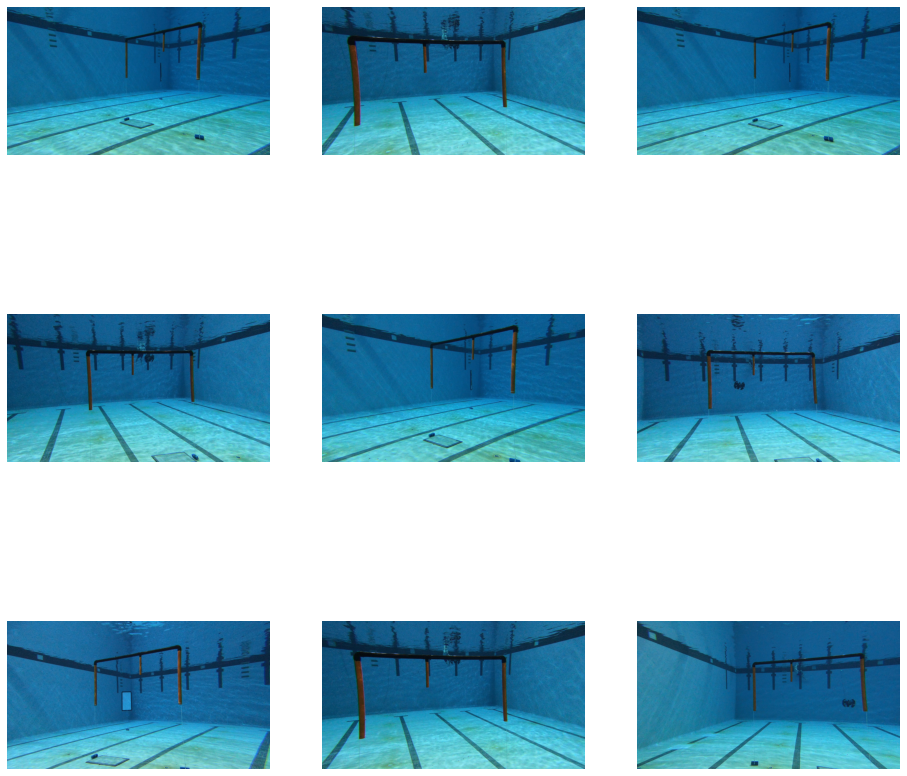

In [7]:
# Sample images from each class
n_columns = 3
n_rows = 3
fig = plt.figure(figsize=(16, 16))
rnd_idx = np.random.randint(0, dataset_size - 1, n_columns * n_rows)
for i in range(n_columns * n_rows):
  img = plt.imread(os.path.join(IMAGES_PATH, str(rnd_idx[i]) + ".jpg"))
  fig.add_subplot(n_rows, n_columns, i + 1)
  plt.imshow(img)
  plt.axis('off')

In [8]:
def resize_image_aspect_ratio(img, new_width=None, new_height=None):
    height, width = img.shape[:2]
    if new_width is not None and new_height is None:
        r = new_width/width
        new_height = int(height * r)
    elif new_width is None and new_height is not None:
        r = new_height/height
        new_width = int(width * r)
    new_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return new_image

In [9]:
def detect_rectangular_contours(frame, area_threshold=300, height_width_ratio=2.5):
    # find the contours from the thresholded image
    contours, hierarchy = cv2.findContours(frame,
                                              cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    result = []
    for contour in contours:
        area = cv2.contourArea(contour)
        # If the contour's area is above a certain threshold
        if area > area_threshold:
            contour_approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
            # If contour is a square or a rectangle
            if (4 <= len(contour_approx) <= 6):
                # If contour is a vertical rectangle
                rectangle = cv2.boundingRect(contour)
                (x, y, width, height) = rectangle
                if (height / height_width_ratio) > width:
                    result.append([rectangle, area])

    if len(result) > 3:
        result = heapq.nlargest(3, result, key=lambda x: x[1])

    return [rectangle for rectangle, _ in result]

In [10]:
def draw_gate(frame, rectangles):
    # Sort the rectangles from left to right
    rectangles = sorted(rectangles, key=lambda x: x[0])

    if len(rectangles) == 3:
        if (rectangles[1][0] - rectangles[0][0]) < (rectangles[2][0] - rectangles[1][0]):
            small_index = 0
            large_index = 2
        else:
            small_index = 2
            large_index = 0

        red_pts = np.array([[rectangles[1][0], rectangles[1][1]],
                            [rectangles[1][0], rectangles[1][1] + rectangles[large_index][3]],
                            [rectangles[large_index][0], rectangles[large_index][1] + rectangles[large_index][3]],
                            [rectangles[large_index][0], rectangles[large_index][1]]],
                            np.int32)

        green_pts = np.array([[rectangles[1][0], rectangles[1][1]],
                            [rectangles[1][0], rectangles[1][1] + rectangles[small_index][3]],
                            [rectangles[small_index][0], rectangles[small_index][1] + rectangles[small_index][3]],
                            [rectangles[small_index][0], rectangles[small_index][1]]],
                            np.int32)

        red_pts = red_pts.reshape((-1, 1, 2))
        green_pts = green_pts.reshape((-1, 1, 2))

        frame = cv2.polylines(frame, [red_pts], True, (0, 0, 255), 3)
        frame = cv2.polylines(frame, [green_pts], True, (0, 255, 0), 3)

    # If only two lines were found draw a bouding rectangle
    elif len(rectangles) == 2:
        pts = np.array([[rectangles[0][0], rectangles[0][1]],
                        [rectangles[0][0], rectangles[0][1] + max(rectangles[0][3], rectangles[1][3])],
                        [rectangles[1][0], rectangles[1][1] + max(rectangles[0][3], rectangles[1][3])],
                        [rectangles[1][0], rectangles[1][1]]],
                        np.int32)
        pts = pts.reshape((-1, 1, 2))
        frame = cv2.polylines(frame, [pts], True, (255, 0, 0), 3)

    # If only one line was found draw a single vertical line
    elif len(rectangles) == 1:
        frame = cv2.line(frame, (rectangles[0][0], 0), (rectangles[0][0], frame.shape[0] - 1), (255, 0, 0), thickness=3)

    return frame

In [11]:
def detect_gate(frame): 
  ORANGE_MIN = np.array([10, 50, 0], np.uint8)
  ORANGE_MAX = np.array([35, 255, 255], np.uint8)
  # Rescale frame size
  frame = resize_image_aspect_ratio(frame, new_width=800, new_height=None)
  # Make a copy of the original frame
  frame_copy = frame.copy()
  # Change color channel from BGR to HSV
  hsv_frame = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2HSV)
  # Apply mask
  thresholded_frame = cv2.inRange(hsv_frame, ORANGE_MIN, ORANGE_MAX)
  # Apply gaussian blur
  thresholded_frame = cv2.GaussianBlur(thresholded_frame, (5, 5), 0)
  # Apply Erosion to remove small noises
  thresholded_frame = cv2.erode(thresholded_frame, np.ones((3, 3), np.uint8), iterations=1)
  # Apply dilation to widen the remaining parts
  thresholded_frame = cv2.dilate(thresholded_frame, np.ones((3, 3), np.uint8), iterations=2)
  # Detect Rectangular contours
  rectangles = detect_rectangular_contours(thresholded_frame)
  # Draw the smallest width as green rectangle, and larger as red rectangle
  frame = draw_gate(frame, rectangles)

  return frame

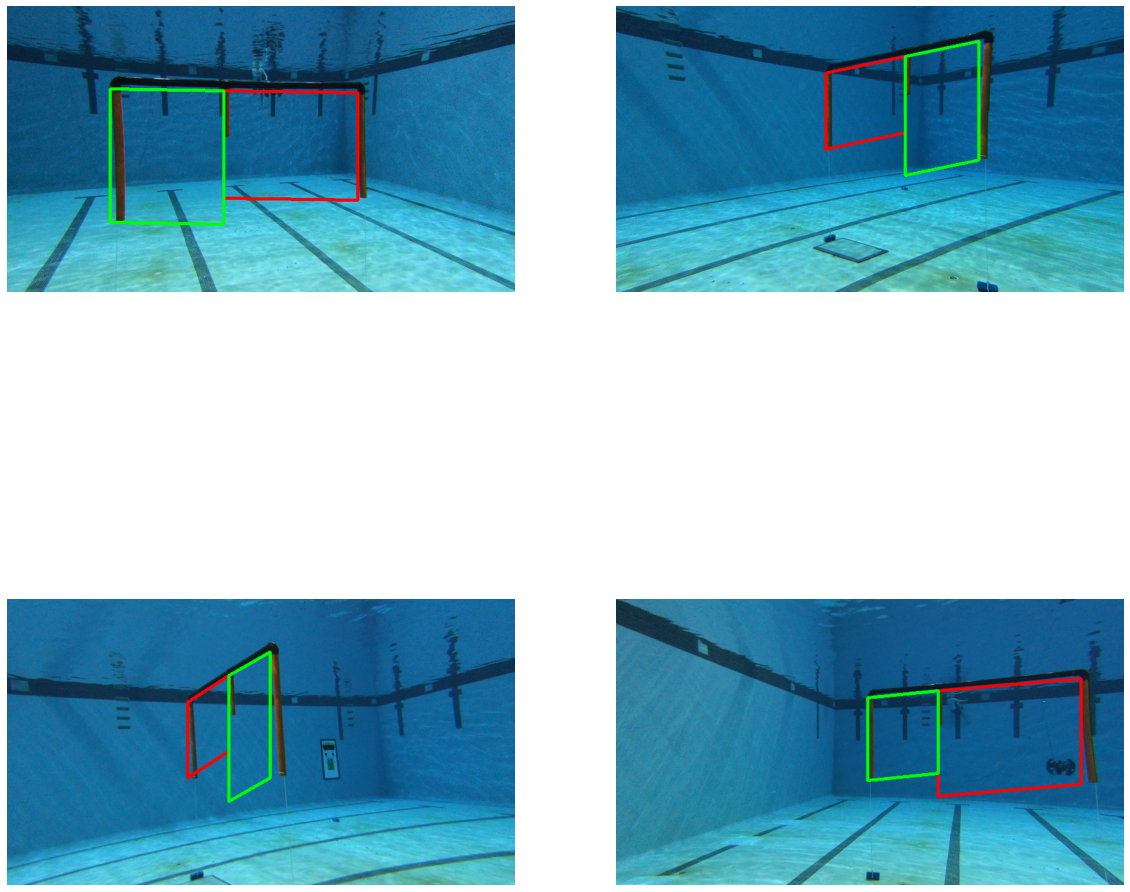

In [12]:
# Detect gate on sample images
n_columns = 2
n_rows = 2
fig = plt.figure(figsize=(20, 20))
rnd_idx = np.random.randint(0, dataset_size - 1, n_columns * n_rows)
for i in range(n_columns * n_rows):
  img = cv2.imread(os.path.join(IMAGES_PATH, str(rnd_idx[i]) + ".jpg"))
  img = detect_gate(img)
  fig.add_subplot(n_rows, n_columns, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')

Saving test.jpg to test.jpg


(-0.5, 799.5, 478.5, -0.5)

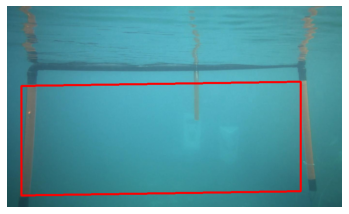

In [13]:
# Upload test image
uploaded = files.upload()
# Get the latest uploaded file
latest_file = max(glob.glob(os.path.join(os.getcwd(), '*')),
                  key=os.path.getctime)
# Read the image
img = plt.imread(latest_file)
# Detect the gate
img = detect_gate(img)
# Display the image
plt.imshow(img)
plt.axis('off')